# OF example

Simulate pulse data, then run OF

Changelog

Oct 22 2024: First version

In [1]:
import sys
import glob
sys.path.append('..')
from arqpy import *

In [2]:
# data + channels to use
chs = ['PAS1','PBS1'] # channels to use (which also serve as dictionary keys)
names = ['inner','outer']

# general
fsamp = 625000 # Hz
pretrig = 4096 # bins
posttrig = 4096
tracelen = pretrig + posttrig # trace used for RQ processing
psdfreq = np.fft.rfftfreq(tracelen,1/fsamp)
ADC2A = 1/2**16 *8/5e3 /2.4/4 # 16-bit ADC, 8V range, 5kOhm R_FB, 2.4 turn ratio, gain = 4

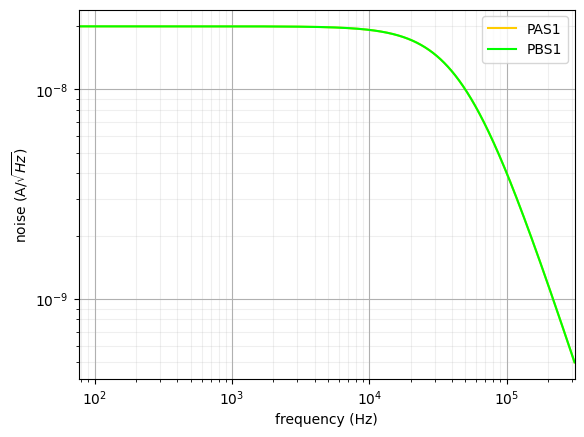

In [3]:
# make PSDs
psdamp = 2e-8
fcut = 5e4
psds = {}
for ch in chs:
    psd = psdamp / (1 + (psdfreq/fcut)**2)
    psds[ch] = psd**2 * (tracelen*fsamp)/2
plotPSDs(psds,tracelen=tracelen)

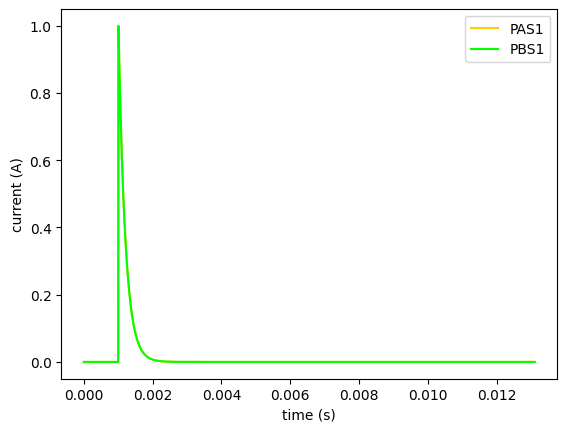

In [4]:
# make pulse templates
templates = {}
t = np.arange(tracelen)/fsamp
pp = (1e-6,2e-4,.001) # pulse parameters
for ch in chs:
    templates[ch] = pulse2(t,*pp)
    
    # plot
    plt.plot(t,templates[ch],color=MIDAScolors[MIDASchs.index(ch)],label=ch)
plt.xlabel('time (s)')
plt.ylabel('current (A)')
plt.legend()

In [5]:
# simulate data
mu = 1e-5
Ntraces = 500
#fulltracelen = 32512
fulltracelen = 16000

fullpsdfreq = np.fft.rfftfreq(fulltracelen,1/fsamp)
psd = psdamp / (1 + (fullpsdfreq/fcut)**2)
psd = psd**2 * (fulltracelen*fsamp)/2
norm = np.sqrt(psd/2)
traces = np.zeros((len(chs),Ntraces,fulltracelen))
t = np.arange(fulltracelen)/fsamp

for i in range(Ntraces):
    for j in range(len(chs)):
        rtJ = np.random.normal(0,1,len(fullpsdfreq))*norm*1j
        rtJ += np.random.normal(0,1,len(fullpsdfreq))*norm
        rtJ[0] = 0
        traces[j][i] = mu*pulse2(t,pp[0],pp[1],t0=.01)
        traces[j][i] += np.fft.irfft(rtJ)

In [6]:
# instantiate Reduced Quantity object
rq = RQ(data=traces, chs=chs, ch_names=names, detector=1,
        fsamp=fsamp, ADC2A=ADC2A,
        pretrig=pretrig, posttrig=posttrig, 
        PSDs=psds, pulse_templates=templates,
        max_chi2_freq=1e4)

In [7]:
# make OF (for RQs AND triggering) and plot
rq.makeOF()

In [8]:
# trigger options
trigger_mode = 1 # 0 - threshold, 1 - filter+threshold, 2 - random, 3 - external/LEMO
randomrate = 0 # random triggers to add per trace
trigger_channels = chs # channels to trigger on
trigger_threshold = [mu*0.8,mu*0.8] #[10,10] # in uA
threshold = {}
deactivation_threshold = {}
for i,ch in enumerate(chs):
    threshold[ch] = trigger_threshold[i]
    deactivation_threshold[ch] = 0.5*threshold[ch]

rq.runTrigger(mode=trigger_mode, chs=trigger_channels, randomrate=randomrate,
              threshold=threshold, deactivation_threshold=deactivation_threshold)

Triggering on 500 events
0 / 500
100 / 500
200 / 500
300 / 500
400 / 500
Found 604


In [9]:
''' #debug trigger...
kwargs = {'mode': trigger_mode, 'chs': trigger_channels, 'randomrate': randomrate,
          'threshold': threshold, 'deactivation_threshold': deactivation_threshold}
keys = ['mode','files','chs','trigger_chs','detector','fsamp','ADC2A','pretrig','posttrig',
        'randomrate','filters','window','usegaus','sigmas','trigger_points',
        'threshold','deactivation_threshold']
trig_kwargs = {} # trigger key word arguments
for key in kwargs:
    trig_kwargs[key] = kwargs[key]
# inherit trigger settings from RQ class, if not yet defined
for key in keys:
    if key not in trig_kwargs:
        if hasattr(rq,key):
            trig_kwargs[key] = getattr(rq,key)
# if no filter defined, try using OF
if 'filters' not in trig_kwargs:
    filters = {}
    for ch in rq.phi_primes:
        filt = np.fft.irfft(rq.phi_primes[ch].conjugate())
        filt *= len(rq.phi_primes[ch]) # (re)normalize
        filters[ch] = filt
    trig_kwargs['filters'] = filters
tg = Trigger(**trig_kwargs)

#traces = tg.runTrigger()

chs = list(set(tg.chs+tg.trigger_chs))
events = loadEvents(files=rq.files,detectors=[rq.detector],chs=chs,ADC2A=rq.ADC2A,loadtrig=False)

trace = events[1]['PFS1'][36]
offset = tg.trigger_offsets['PFS1']
filtered_trace = tg._apply_filter(trace,filters[ch])
plt.plot(trace)
plt.plot(np.arange(len(filtered_trace))-offset,filtered_trace)

trigger_points = tg._threshold_trigger(filtered_trace,0.2e-6,trigger_offset=offset)
print(trigger_points)

for t in trigger_points:
    plt.axvline(t,color='k',alpha=0.3)
#'''

" #debug trigger...\nkwargs = {'mode': trigger_mode, 'chs': trigger_channels, 'randomrate': randomrate,\n          'threshold': threshold, 'deactivation_threshold': deactivation_threshold}\nkeys = ['mode','files','chs','trigger_chs','detector','fsamp','ADC2A','pretrig','posttrig',\n        'randomrate','filters','window','usegaus','sigmas','trigger_points',\n        'threshold','deactivation_threshold']\ntrig_kwargs = {} # trigger key word arguments\nfor key in kwargs:\n    trig_kwargs[key] = kwargs[key]\n# inherit trigger settings from RQ class, if not yet defined\nfor key in keys:\n    if key not in trig_kwargs:\n        if hasattr(rq,key):\n            trig_kwargs[key] = getattr(rq,key)\n# if no filter defined, try using OF\nif 'filters' not in trig_kwargs:\n    filters = {}\n    for ch in rq.phi_primes:\n        filt = np.fft.irfft(rq.phi_primes[ch].conjugate())\n        filt *= len(rq.phi_primes[ch]) # (re)normalize\n        filters[ch] = filt\n    trig_kwargs['filters'] = filters

In [10]:
# Run optimal filter, etc. to derive RQs
rq.processTraces()

# results are stored in rq.results
RQs = rq.results

Processing PAS1. 604 events
Processing PBS1. 604 events


The optimal filter has been run! Now let's look at some RQs...

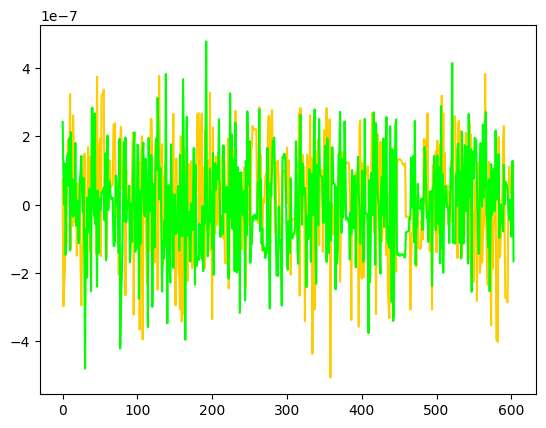

In [11]:
# look at baselines
for ch in chs:
    baselines = RQs[f'MeanBase_{ch}']
    plt.plot(baselines,color=MIDAScolors[MIDASchs.index(ch)])

"\n# could do this manually like so:\nbins=np.linspace(0,mu*2,200)\nfor ch in chs:\n    plt.hist(RQs[f'OF_A_{ch}'],bins=bins,histtype='step',label=ch)\n    plt.legend()\n"

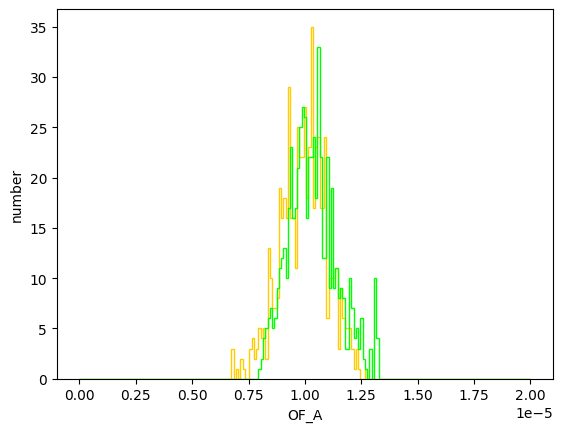

In [12]:
# "spectrum" plot
bins = np.linspace(0,mu*2,200)
for i in range(len(chs)):
    rq.hist1d('OF_A_{0}'.format(chs[i]),bins=bins)

'''
# could do this manually like so:
bins=np.linspace(0,mu*2,200)
for ch in chs:
    plt.hist(RQs[f'OF_A_{ch}'],bins=bins,histtype='step',label=ch)
    plt.legend()
'''

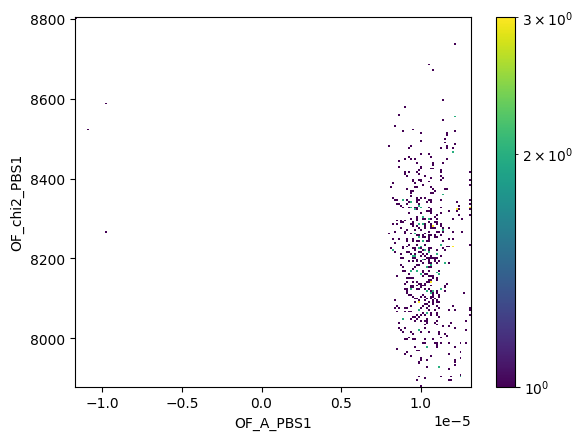

In [13]:
# chi2 vs amplitude plot
ch = chs[1]
rq.hist2d(f'OF_A_{ch}',f'OF_chi2_{ch}')
# format

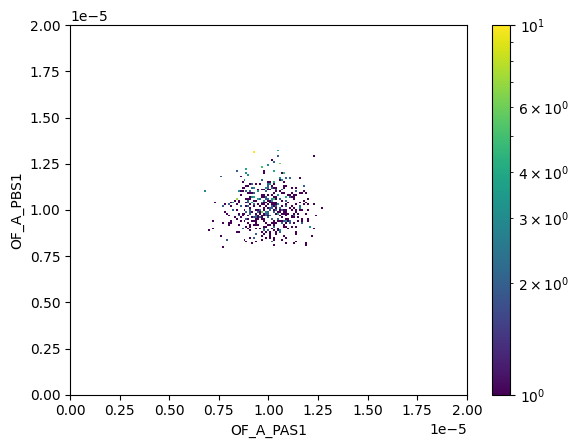

In [14]:
# "partition" plot
ch0,ch1 = chs
bins = (np.linspace(0,2*mu,200),np.linspace(0,2*mu,200))
rq.hist2d(f'OF_A_{ch0}',f'OF_A_{ch1}',bins=bins)
# format

In [15]:
# data matches theory?
theores = rq.getTheoryRes()
for ch in chs:
    print(f'{ch} theory: ',theores[ch])
    
    vals = RQs[f'OF_A_{ch}']
    posvals = vals[vals>0]
    print(f'{ch} measure:',np.std(posvals))

PAS1 theory:  1.0334935601832874e-06
PAS1 measure: 1.0383372e-06
PBS1 theory:  1.0334935601832874e-06
PBS1 measure: 1.0814116e-06
